In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import datetime
from plotly.offline import iplot
import yfinance as yf
import talib

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
need_row_data = False
load_data = True

seed = 42

period = '6y'
interval = '1d'

day_after = 1

N = 10 

train_size = 0.9          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.9

# Load data

In [3]:
if need_row_data:
    csvs = [
        '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'
    ]

    tickers = pd.DataFrame()
    for csv in csvs:
        data = pd.read_csv(f'data/row_jap/{csv}.csv')
        tickers = pd.concat([tickers, data], axis=0)

    with open('models/row_jap_stock.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tickers = tickers[['ｺｰﾄﾞ', '会社名', '業種', '時価総額\r\n(10億円)']]
    tickers.rename(columns={"ｺｰﾄﾞ": "ticker", "会社名": "company", "業種":"sector", "時価総額\r\n(10億円)": "market_cap"}, inplace=True)
    tickers.replace(',','', regex=True, inplace=True)
    tickers['market_cap'] = tickers['market_cap'].astype(str).astype(int)

    with open('data/jap_ticker.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/jap_ticker.pickle', 'rb') as handle:
        tickers = pickle.load(handle)

tickers.head()

,ticker,company,sector,market_cap
0,7203,トヨタ自動車,自動車・自動車部品,33576
1,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上,その他金融,15764
2,9432,日本電信電話,通信,13858
3,6758,ソニーグループ,電気機器,13658
4,6861,キーエンス,電気機器,11667


In [4]:
if load_data:
    dfs = []

#    forex_data = yf.download('USDJPY=X', period=period, interval=interval, progress=False)
#    forex_data.rename({"Adj Close": 'forex'}, inplace=True, axis=1)
#    forex = forex_data[['forex']]
#
#    dji_data = yf.download('^dji', period=period, interval=interval, progress=False)
#    dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
#    dji = dji_data[['dji']]#.shift(1)
#
#    sp500_data = yf.download(tickers='^GSPC', period=period, interval=interval, progress=False)
#    sp500_data.rename({"Adj Close": 'sp500'}, inplace=True, axis=1)
#    sp500 = sp500_data[['sp500']]
#
#    n225_data = yf.download(tickers='^N225', period=period, interval=interval, progress=False)
#    n225_data.rename({"Adj Close": 'n225'}, inplace=True, axis=1)
#    n225 = n225_data[['n225']].shift(1)
#
#    bond13_data = yf.download(tickers='^IRX', period=period, interval=interval, progress=False)
#    bond13_data.rename({"Adj Close": 'bond13'}, inplace=True, axis=1)
#    bond13 = bond13_data[['bond13']]
#
#    bond5_data = yf.download(tickers='^FVX', period=period, interval=interval, progress=False)
#    bond5_data.rename({"Adj Close": 'bond5'}, inplace=True, axis=1)
#    bond5 = bond5_data[['bond5']]

    for i, company in tqdm_notebook(tickers.iterrows(), total=len(tickers)):
        ticker = str(company["ticker"]) + '.T'
        try:
            temp_df = yf.download(ticker, period=period, interval=interval, progress=False)
            # create ticker column and sector column
            #temp_df = pd.concat([temp_df, forex, dji, n225, sp500, bond13, bond5], axis=1, join='inner')
            temp_df['ticker'] = ticker
            temp_df['sector'] = company["sector"]

            dfs.append(temp_df)
        except Exception as e: print(e)

else:
    with open('data/jp_company_data_2022_7_7.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].tail()

  0%|          | 0/300 [00:00<?, ?it/s]

,Open,High,Low,Close,Adj Close,Volume,ticker,sector
Date,,,,,,,,
2022-07-21,2191.0,2206.0,2175.0,2193.5,2193.5,24208700,7203.T,自動車・自動車部品
2022-07-22,2199.5,2204.5,2190.0,2202.5,2202.5,20867700,7203.T,自動車・自動車部品
2022-07-25,2177.0,2198.5,2163.0,2166.0,2166.0,16534400,7203.T,自動車・自動車部品
2022-07-26,2177.5,2182.5,2160.0,2166.0,2166.0,12369100,7203.T,自動車・自動車部品
2022-07-27,2154.0,2174.0,2142.0,2169.0,2169.0,15783800,7203.T,自動車・自動車部品


In [5]:
#for df in dfs:
#    df.drop(columns=['forex', 'dji', 'n225', 'sp500', 'bond13', 'bond5'], inplace=True)

In [6]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-1*day_after) / temp_df['adj_close'])-1)
    temp_df['volatility'] = (temp_df['high'] - temp_df['low'])/temp_df['high']
    #temp_df['dji_ret'] = 100.0 * ((temp_df['dji'].shift(1) / temp_df['dji'])-1)*-1
    #temp_df['forex_ret'] = 100.0 * ((temp_df['forex'].shift(1) / temp_df['forex'])-1)*-1
    #temp_df['sp500_ret'] = 100.0 * ((temp_df['sp500'].shift(1) / temp_df['sp500'])-1)*-1
    #temp_df['n225_ret'] = 100.0 * ((temp_df['n225'].shift(1) / temp_df['n225'])-1)*-1
    #temp_df['bond13_ret'] = 100.0 * ((temp_df['bond13'].shift(1) / temp_df['bond13'])-1)*-1
    #temp_df['bond5_ret'] = 100.0 * ((temp_df['bond5'].shift(1) / temp_df['bond5'])-1)*-1

    # create weekday column
    date = pd.to_datetime(temp_df['date']).dt
    temp_df['weekday'] = date.weekday
    temp_df['month'] = date.month

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].tail()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,volatility,weekday,month
1481,2022-07-21,2191.0,2206.0,2175.0,2193.5,2193.5,24208700,7203.T,自動車・自動車部品,0.410303,0.014053,3,7
1482,2022-07-22,2199.5,2204.5,2190.0,2202.5,2202.5,20867700,7203.T,自動車・自動車部品,-1.657208,0.006577,4,7
1483,2022-07-25,2177.0,2198.5,2163.0,2166.0,2166.0,16534400,7203.T,自動車・自動車部品,0.000000,0.016147,0,7
1484,2022-07-26,2177.5,2182.5,2160.0,2166.0,2166.0,12369100,7203.T,自動車・自動車部品,0.138504,0.010309,1,7
1485,2022-07-27,2154.0,2174.0,2142.0,2169.0,2169.0,15783800,7203.T,自動車・自動車部品,NaN,0.014719,2,7


# Feature Engineering

## Simple Moving Average

In [7]:
# Simple moving average
for temp_df in dfs:
    sma_10 = temp_df['adj_close'].rolling(window = 10).mean()
    sma_20 = temp_df['adj_close'].rolling(window = 20).mean()
    sma_50 = temp_df['adj_close'].rolling(window = 50).mean()
    sma_100 = temp_df['adj_close'].rolling(window = 100).mean()
    sma_200 = temp_df['adj_close'].rolling(window = 200).mean()

    # get the moving average ratio
    temp_df['sma_10_r'] = (temp_df['adj_close'] - sma_10)/sma_10 * 100
    temp_df['sma_20_r'] = (temp_df['adj_close'] - sma_20)/sma_20 * 100
    temp_df['sma_50_r'] = (temp_df['adj_close'] - sma_50)/sma_50 * 100
    temp_df['sma_100_r'] = (temp_df['adj_close'] - sma_100)/sma_100 * 100
    temp_df['sma_200_r'] = (temp_df['adj_close'] - sma_200)/sma_200 * 100

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10_r'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20_r'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50_r'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100_r'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200_r'].shift(1)


        # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > sma_20).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > sma_50).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > sma_100).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > sma_200).astype(int)

    temp_df['sma_10above20'] = (sma_10 > sma_20).astype(int)
    temp_df['sma_10above50'] = (sma_10 > sma_50).astype(int)
    temp_df['sma_10above100'] = (sma_10 > sma_100).astype(int)
    temp_df['sma_10above200'] = (sma_10 > sma_200).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < sma_20)).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < sma_50)).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < sma_100)).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < sma_200)).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (sma_10 < sma_20)).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (sma_10 < sma_50)).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (sma_10 < sma_100)).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (sma_10 < sma_200)).astype(int)

    dfs[0].head()

In [8]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [9]:
for df in dfs:
    # Exponential moving average
    ema_10 = talib.EMA(df['adj_close'], 10)
    ema_20 = talib.EMA(df['adj_close'], 20)
    ema_50 = talib.EMA(df['adj_close'], 50)
    ema_100 = talib.EMA(df['adj_close'], 100)
    ema_200 = talib.EMA(df['adj_close'], 200)

    df['ema_10_r'] = (df['adj_close'] - ema_10)/ema_10 * 100
    df['ema_20_r'] = (df['adj_close'] - ema_20)/ema_20 * 100
    df['ema_50_r'] = (df['adj_close'] - ema_50)/ema_50 * 100
    df['ema_100_r'] = (df['adj_close'] - ema_100)/ema_100 * 100
    df['ema_200_r'] = (df['adj_close'] - ema_200)/ema_200 * 100

    # Get the ema on the previous day
    df['ema_10_lag_1'] = df['ema_10_r'].shift(1)
    df['ema_20_lag_1'] = df['ema_20_r'].shift(1)
    df['ema_50_lag_1'] = df['ema_50_r'].shift(1)
    df['ema_100_lag_1'] = df['ema_100_r'].shift(1)
    df['ema_200_lag_1'] = df['ema_200_r'].shift(1)


        # Get above signals
    df['ema_above20'] = (df['adj_close'] > ema_20).astype(int)
    df['ema_above50'] = (df['adj_close'] > ema_50).astype(int)
    df['ema_above100'] = (df['adj_close'] > ema_100).astype(int)
    df['ema_above200'] = (df['adj_close'] > ema_200).astype(int)

    df['ema_10above20'] = (ema_10 > ema_20).astype(int)
    df['ema_10above50'] = (ema_10 > ema_50).astype(int)
    df['ema_10above100'] = (ema_10 > ema_100).astype(int)
    df['ema_10above200'] = (ema_10 > ema_200).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < ema_20)).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < ema_50)).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < ema_100)).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < ema_200)).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (ema_10 < ema_20)).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (ema_10 < ema_50)).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (ema_10 < ema_100)).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (ema_10 < ema_200)).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-27,1149.199951,1184.000000,1146.800049,1173.199951,909.810242,60774500,7203.T,自動車・自動車部品,-0.119339,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-28,1163.000000,1176.400024,1161.599976,1171.800049,908.724487,42386500,7203.T,自動車・自動車部品,0.597372,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-29,1151.800049,1182.000000,1141.599976,1178.800049,914.152954,81390500,7203.T,自動車・自動車部品,-1.645744,...,0,0,0,0,0,0,0,0,0,0
3,2016-08-01,1143.000000,1166.000000,1140.800049,1159.400024,899.108337,47061500,7203.T,自動車・自動車部品,-1.742293,...,0,0,0,0,0,0,0,0,0,0
4,2016-08-02,1148.000000,1154.800049,1139.000000,1139.199951,883.443237,46550000,7203.T,自動車・自動車部品,-1.878518,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [11]:
for df in tqdm_notebook(dfs):
    fast_period = 12
    slow_period = 26
    signal_period = 9
    macd, macd_signal, _ = talib.MACD(df['adj_close'], fast_period, slow_period, signal_period)

    df['macd'] = macd
    df['macd_signal'] = macd_signal

    # Get the macd on the previous day
    df['macd_lag_1'] = macd.shift(1)
    df['macd_signal_lag_1'] = macd_signal.shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-27,1149.199951,1184.000000,1146.800049,1173.199951,909.810242,60774500,7203.T,自動車・自動車部品,-0.119339,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
1,2016-07-28,1163.000000,1176.400024,1161.599976,1171.800049,908.724487,42386500,7203.T,自動車・自動車部品,0.597372,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
2,2016-07-29,1151.800049,1182.000000,1141.599976,1178.800049,914.152954,81390500,7203.T,自動車・自動車部品,-1.645744,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
3,2016-08-01,1143.000000,1166.000000,1140.800049,1159.400024,899.108337,47061500,7203.T,自動車・自動車部品,-1.742293,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
4,2016-08-02,1148.000000,1154.800049,1139.000000,1139.199951,883.443237,46550000,7203.T,自動車・自動車部品,-1.878518,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0


In [12]:
# Del unneccesary cols
for df in dfs:
    df.drop(['macd_signal', 
        #'macd_lag_1', 'macd_signal_lag_1'
        ], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [13]:
for df in tqdm_notebook(dfs):
    # Generate fast and slow stochastic oscillators
    df['stochastic_fast'], df['stochastic_slow'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3,
                        slowk_matype=0, slowd_period=3, slowd_matype=0)

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,macd_crossover,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-27,1149.199951,1184.000000,1146.800049,1173.199951,909.810242,60774500,7203.T,自動車・自動車部品,-0.119339,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-28,1163.000000,1176.400024,1161.599976,1171.800049,908.724487,42386500,7203.T,自動車・自動車部品,0.597372,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-29,1151.800049,1182.000000,1141.599976,1178.800049,914.152954,81390500,7203.T,自動車・自動車部品,-1.645744,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-08-01,1143.000000,1166.000000,1140.800049,1159.400024,899.108337,47061500,7203.T,自動車・自動車部品,-1.742293,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-08-02,1148.000000,1154.800049,1139.000000,1139.199951,883.443237,46550000,7203.T,自動車・自動車部品,-1.878518,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0


In [14]:
# Del unneccesary cols
for df in dfs:
    df.drop([#'lowest_14',
             #'highest_14',
             'stochastic_fast_lag_1',
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [15]:
for df in tqdm_notebook(dfs):
    df['rsi'] = talib.RSI(df['adj_close'], 14)

    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0][20:25]

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,rsi,rsi_ob,rsi_os
20,2016-08-25,1220.000000,1225.400024,1214.599976,1223.199951,948.584717,33962500,7203.T,自動車・自動車部品,-3.351866,...,0,92.321411,91.883354,0,0,0,1,57.788686,0,0
21,2016-08-26,1200.000000,1201.599976,1182.199951,1182.199951,916.789429,60470500,7203.T,自動車・自動車部品,3.992576,...,0,71.073627,85.394103,0,1,0,0,48.967202,0,0
22,2016-08-29,1221.199951,1237.199951,1216.400024,1229.400024,953.392944,57901500,7203.T,自動車・自動車部品,0.634434,...,0,67.376114,76.923718,0,0,0,0,57.088371,0,0
23,2016-08-30,1230.000000,1249.000000,1230.000000,1237.199951,959.441589,61693000,7203.T,自動車・自動車部品,0.840657,...,0,63.162211,67.203984,0,0,0,0,58.270149,0,0
24,2016-08-31,1260.000000,1270.599976,1247.599976,1247.599976,967.507202,70927000,7203.T,自動車・自動車部品,0.737381,...,0,82.877107,71.138477,1,0,0,1,59.857698,0,0


In [16]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['gain', 
#             'loss'
#            ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [17]:
for df in dfs:
    atr_value = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['atr'] = atr_value/atr_value.min()

    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    close_lag_1 = df['close'].shift(1)
    df['atr_signal'] = (df['high'] > (close_lag_1 + df['atr'])).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < (close_lag_1 - df['atr'])).astype(int)

In [18]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['close_lag_1'], axis=1, inplace=True)

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [19]:
for i, df in tqdm_notebook(enumerate(dfs), total=len(dfs)):

    adx = talib.ADX(df['high'], df['low'], df['close'],timeperiod=14)
    df['adx'] = adx

    # Get +/- directional index
    df['+di'] = talib.PLUS_DI(df['high'], df['low'], df['close'],timeperiod=14)
    df['-di'] = talib.MINUS_DI(df['high'], df['low'], df['close'],timeperiod=14)

    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)

    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


  0%|          | 0/300 [00:00<?, ?it/s]

In [20]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['+di',
#             '-di',
#             '+di_lag_1',
#             '-di_lag_1',
#             'tr', 
#             '+dm', 
#             '-dm', 
#             'smoothed+dm',
#             'smoothed-dm',
#             '14tr',
#             'dx',
#             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [21]:
for df in dfs:
    u_band, m_band, l_band = talib.BBANDS(df['adj_close'], timeperiod=10,
                                   nbdevup=2, nbdevdn=2, matype=0)

    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = u_band - df['adj_close']
    df['bollinger_mid_dist'] = df['adj_close'] - m_band
    df['bollinger_low_dist'] = df['adj_close'] - l_band

    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > u_band).astype(int)
    df['bollinger_os'] = (df['adj_close'] < l_band).astype(int)
    df['bollinger_om'] = (df['adj_close'] > u_band).astype(int)

In [22]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [23]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'adj_close_lag_1',
             #'dji',
             #'n225',
             #'sp500',
             #'bond13',
             #'bond5',
             ], axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 0 to 1485
Columns: 103 entries, date to bollinger_om
dtypes: datetime64[ns](1), float64(33), int64(67), object(2)
memory usage: 1.2+ MB


# EDA

In [25]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in tqdm_notebook(dfs):
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [26]:
# create lag for daily return to N days ahead
for df in dfs:
    df['temp_ret'] = 100.0 * ((df['adj_close'].shift(1) / df['adj_close'])-1)*-1
    #df.drop(['index'], axis=1, inplace=True)
dfs_lags = add_lags(dfs, ['temp_ret'], N)
#dfs_lags = add_lags(dfs_lags, ['forex_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['sp500_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['n225_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['bond13_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['bond5_ret'], 4)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1486, 113)

In [27]:
temp_ret = 100.0 * ((df['adj_close'].shift(1) / df['adj_close'])-1)*-1
temp_ret

0            NaN
1       2.057989
2      -1.135288
3      -2.721094
4      -2.083324
          ...   
1481   -0.495942
1482    0.224921
1483   -1.506849
1484    0.904977
1485    0.315742
Name: adj_close, Length: 1486, dtype: float64

In [28]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(
    ['date', 'daily_ret', 'sector', 'ticker', 'weekday', 'month', 'year', 
        'dji', 'dji_ret', 'forex', 'forex_ret', 'sp500', 'sp500_ret', 'n225', 'n225_ret', 'bond13', 'bond13_ret', 'bond5', 'bond5_ret', 'volatility']
    ))
tech_indicators.sort()

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1486, 206)

In [29]:
#for df in dfs_lags:
#    df.drop([f'{tech_indicator}_lag_1' for tech_indicator in tech_indicators], axis=1, inplace=True)

In [30]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
dfs_lags[0].shape

(1486, 109)

# Encode Label

In [31]:
#with open('temp/v8_predict.pickle', 'wb') as handle:
#    pickle.dump(dfs_lags, handle)

In [32]:
df_lags = pd.concat(dfs_lags)

In [33]:
df_lags.shape

(443396, 109)

In [34]:
df_lags = df_lags[(abs(df_lags['daily_ret']) <= 50) | (df_lags['daily_ret'].isna())]

In [35]:
with open('v8/enc_date.pickle', 'rb') as handle:
    date_encoder = pickle.load(handle)

with open('v8/enc_sector.pickle', 'rb') as handle:
    sector_encoder = pickle.load(handle)

with open('v8/enc_ticker.pickle', 'rb') as handle:
    ticker_encoder = pickle.load(handle)

In [36]:

a = np.array([pd.Timestamp(date) for date in date_encoder.classes_])
date_encoder_dict = dict(zip(a, date_encoder.transform(date_encoder.classes_)))

last_date = list(date_encoder_dict.keys())[-1]
last_date_encoder = list(date_encoder_dict.values())[-1]
for i in range(1, 365):
    new_date = last_date + np.timedelta64(i, 'D')
    last_date_encoder += 1
    date_encoder_dict[new_date] = last_date_encoder

In [37]:
# label encode for categorical variables: sector and ticker column
df_lags['date'] = df_lags['date'].apply(
    lambda x: date_encoder_dict.get(x)
)
df_lags['sector'] = sector_encoder.transform(df_lags['sector'])

df_lags['ticker'] = ticker_encoder.transform(df_lags['ticker'])
df_lags.head()

,date,ticker,sector,daily_ret,volatility,weekday,month,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
0,12.0,186,21,-0.119339,0.031419,2,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.0,186,21,0.597372,0.012581,3,7,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,14.0,186,21,-1.645744,0.034179,4,7,-0.119481,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,15.0,186,21,-1.742293,0.021612,0,8,0.593825,-0.119481,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,16.0,186,21,-1.878518,0.013682,1,8,-1.673282,0.593825,-0.119481,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [38]:
df_lags[df_lags['date'] == (df_lags['date'].max())].tail()

,date,ticker,sector,daily_ret,volatility,weekday,month,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1485,1430.0,231,27,NaN,0.010582,2,7,1.415929,-0.718133,-0.534759,...,0.0,0.0,0.0,0.0,60.465116,0.0,0.0,0.0,0.0,57.720930
1485,1430.0,85,9,NaN,0.020484,2,7,-1.333333,-1.127820,1.301115,...,0.0,0.0,0.0,0.0,83.859649,0.0,0.0,1.0,0.0,91.376796
1485,1430.0,283,29,NaN,0.019362,2,7,-1.152074,1.025057,-1.495972,...,0.0,1.0,0.0,0.0,21.097046,0.0,0.0,0.0,0.0,27.993832
1485,1430.0,284,29,NaN,0.019128,2,7,0.223514,1.478495,-1.546157,...,0.0,1.0,0.0,0.0,29.928315,0.0,0.0,0.0,0.0,30.884110
1485,1430.0,70,9,NaN,0.018468,2,7,0.904977,-1.506849,0.224921,...,1.0,1.0,0.0,1.0,63.073624,0.0,0.0,0.0,0.0,62.563903


# Predicting data

In [39]:
non_na = list(df_lags.columns)
non_na.remove('daily_ret')
df_lags.dropna(subset=non_na, inplace=True)

In [40]:
pd.set_option('display.max_columns', 500)

In [41]:
temp = df_lags.copy(deep=True)

In [42]:
df_lags = temp.copy(deep=True)

In [55]:
days_ago = 0
get_models = False

In [56]:
columns = list(df_lags.columns)
deleting = []
deleting_words = ['bollinger', 'sma', 'di', 'adx', 'ema', 'macd', 'rsi', 'stochastic', 'weekday', 'month']
for col in columns:
    if any(word in col for word in deleting_words):
        deleting.append(col)

df_lags.drop(columns=deleting, inplace=True)

In [57]:
predicting = df_lags[df_lags['date'] == (df_lags['date'].max() - days_ago)]#df_lags.sort_values(by='date')[-20000:]
while not predicting.shape[0]:
    days_ago += 1
    predicting = df_lags[df_lags['date'] == (df_lags['date'].max() - days_ago)]
predicting.drop(columns=['date'], inplace=True)
actual = predicting['daily_ret']
predicting.drop(['daily_ret'], axis=1, inplace=True)

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_96101/486626462.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_96101/486626462.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
predicting.tail()

,ticker,sector,volatility,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,temp_ret_lag_4,temp_ret_lag_5,temp_ret_lag_6,temp_ret_lag_7,temp_ret_lag_8,temp_ret_lag_9,adj_close_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1
1485,231,27,0.010582,1.415929,-0.718133,-0.534759,0.709220,2.678571,0.366972,-1.841621,-1.989150,0.354610,5650.0,1.751550,1.0,0.0
1485,85,9,0.020484,-1.333333,-1.127820,1.301115,-0.188324,3.195489,-0.970874,0.576923,0.967118,0.585938,5250.0,2.886340,1.0,1.0
1485,283,29,0.019362,-1.152074,1.025057,-1.495972,-1.133787,-0.560538,-2.229654,2.399128,-1.229050,2.317881,868.0,1.673477,1.0,1.0
1485,284,29,0.019128,0.223514,1.478495,-1.546157,-1.030004,-0.044326,-1.683651,0.522876,-0.700832,0.478469,2237.0,2.498086,1.0,0.0
1485,70,9,0.018468,0.904977,-1.506849,0.224921,-0.495942,4.037685,0.607761,-0.564440,0.233863,-0.984529,2210.0,1.974014,1.0,0.0


In [59]:
if get_models:
    with open('v8/rf_model.pickle', 'rb') as handle:
        rf = pickle.load(handle)
    
    with open('v8/rf_model2.pickle', 'rb') as handle:
        rf2 = pickle.load(handle)
    
    with open('v8/xgb_model.pickle', 'rb') as handle:
        xgb = pickle.load(handle)
    
    with open('v8/xgbclf_model.pickle', 'rb') as handle:
        xgbclf = pickle.load(handle)
    
    with open('v8/lgbm_model.pickle', 'rb') as handle:
        lbgm = pickle.load(handle)
    
    with open('v8/ridge_model.pickle', 'rb') as handle:
        ridge = pickle.load(handle)

# Predict with models

In [60]:
tech_indicators = [
    'sma_above20',
    'sma_above50',
    'sma_above100',
    'sma_above200',
    'sma_10above20',
    'sma_10above50',
    'sma_10above100',
    'sma_10above200',
    'sma_cut20',
    'sma_cut50',
    'sma_cut100',
    'sma_cut200',
    'sma_10cut20',
    'sma_10cut50',
    'sma_10cut100',
    'sma_10cut200',
    'sma_cut20down',
    'sma_cut50down',
    'sma_cut100down',
    'sma_cut200down',
    'sma_10cut20down',
    'sma_10cut50down',
    'sma_10cut100down',
    'sma_10cut200down',
    'ema_above20',
    'ema_above50',
    'ema_above100',
    'ema_above200',
    'ema_10above20',
    'ema_10above50',
    'ema_10above100',
    'ema_10above200',
    'ema_cut20',
    'ema_cut50',
    'ema_cut100',
    'ema_cut200',
    'ema_10cut20',
    'ema_10cut50',
    'ema_10cut100',
    'ema_10cut200',
    'ema_cut20down',
    'ema_cut50down',
    'ema_cut100down',
    'ema_cut200down',
    'ema_10cut20down',
    'ema_10cut50down',
    'ema_10cut100down',
    'ema_10cut200down',
    'macd',
    'macd_crossover',
    'macd_crossoverdown',
    'stochastic_fast',
    'stochastic_slow',
    'stochastic_fastcutslow',
    'stochastic_fastcutslowdown',
    'stochastic_overs',
    'stochastic_overb',
    'rsi',
    'rsi_ob',
    'rsi_os',
    'bollinger_upp_dist',
    'bollinger_low_dist',
    'bollinger_ob',
    'bollinger_os'
]

In [61]:
def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    #ax.set_xlim([-30, 30])
    #ax.set_ylim([-30, 30])

    ax.set_aspect('equal')

In [62]:
with open('v8/lgbm_model5.pickle', 'rb') as handle:
    lbgm = pickle.load(handle)

In [63]:
prediction = lbgm.predict(predicting)
if days_ago:
    print(lbgm.score(predicting, actual))

In [64]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

lgbm_result = pd.DataFrame(data)
lgbm_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in lgbm_result.index]

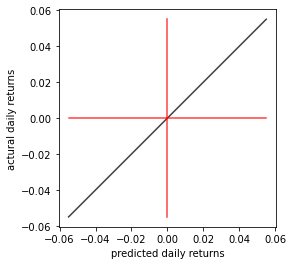

In [65]:
show_prediction_scatter(prediction, actual)

In [66]:
top10 = lgbm_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average 3: {top10['actual'].head(3).sum()/3}")
print(f"average 5: {top10['actual'].head(5).sum()/5}")
print(f"average 10: {top10['actual'].sum()/10}")
print(top10)
print(top10.head(5).index)

average 3: 0.0
average 5: 0.0
average 10: 0.0
        prediction  actual
8355.T    4.243408     NaN
1803.T    3.632653     NaN
5332.T    3.560065     NaN
8984.T    3.470702     NaN
9697.T    3.340552     NaN
8630.T    3.246160     NaN
9143.T    3.238114     NaN
7181.T    2.979779     NaN
8331.T    2.948003     NaN
7186.T    2.947348     NaN
Index(['8355.T', '1803.T', '5332.T', '8984.T', '9697.T'], dtype='object')


## Random Forest

In [ ]:
with open('v8/rf_model2.pickle', 'rb') as handle:
    rf = pickle.load(handle)

### Predict

In [ ]:
prediction = rf.predict(predicting)

In [ ]:
rf.score(predicting, actual)

-0.028498960064333723

In [ ]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

rf_result = pd.DataFrame(data)
rf_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in rf_result.index]

### Result

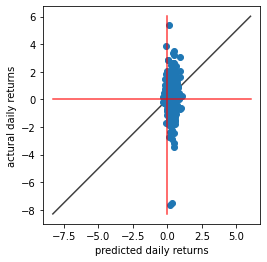

In [ ]:
show_prediction_scatter(prediction, actual)

In [ ]:
top10 = rf_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 0.7045680567200951
        prediction    actual
7532.T    1.062149  0.241546
7309.T    0.972317 -0.635641
7747.T    0.932722  3.054101
6869.T    0.919851  2.080898
7936.T    0.912035  1.622060
2651.T    0.882533 -0.730689
5713.T    0.847979  0.431691
6532.T    0.843022  0.000000
7011.T    0.817195  0.101235
9984.T    0.777567  0.880480


## Random Forest2

### Predict

In [ ]:
prediction = rf2.predict(predicting)

In [ ]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

rf2_result = pd.DataFrame(data)
rf2_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in rf2_result.index]

### Result

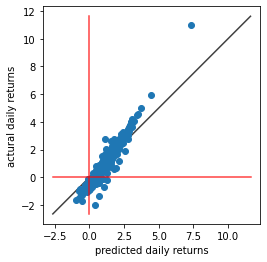

In [ ]:
show_prediction_scatter(prediction, actual)

In [ ]:
top10 = rf2_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 5.078728214819316
        prediction     actual
8267.T    7.336535  10.971524
7936.T    4.440756   5.953878
7532.T    3.753631   4.967386
2127.T    3.530601   4.594767
3769.T    3.465173   4.523580
2181.T    3.186944   4.095164
2897.T    3.079459   3.915344
6098.T    3.069746   4.189526
6758.T    3.066703   3.647276
3092.T    3.005637   3.928836


## XGBOOST

### Predict

In [ ]:
prediction = xgb.predict(predicting)

In [ ]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 2127.T
Predicted max daily return: 2.6664371490478516


In [ ]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

xgb_result = pd.DataFrame(data)
xgb_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in xgb_result.index]

### Result

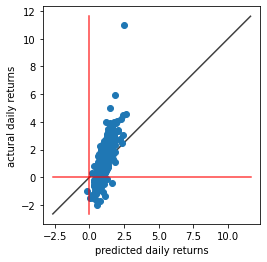

In [ ]:
show_prediction_scatter(prediction, actual)

In [ ]:
top10 = xgb_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 4.343025372463134
        prediction     actual
2127.T    2.666437   4.594767
8267.T    2.525169  10.971524
3769.T    2.407281   4.523580
6967.T    2.406476   3.039514
6920.T    2.347917   2.504526
6098.T    2.274603   4.189526
3064.T    2.171466   2.749446
6702.T    2.091142   3.327596
6532.T    2.055919   3.434610
2181.T    1.964093   4.095164


## XGBOOST Classification

### Predict

In [ ]:
xgbclf_result = xgbclf.predict(predicting)

In [ ]:
proba = xgbclf.predict_proba(predicting)

In [ ]:
xgbclf_proba = pd.DataFrame(proba)

In [ ]:
xgbclf_proba.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in xgbclf_proba.index]
xgbclf_proba.head()

,0,1
7203.T,0.216452,0.783548
1306.T,0.407166,0.592834
9432.T,0.350421,0.649579
6758.T,0.235589,0.764411
6861.T,0.202156,0.797844


## LightBGM

### Predict

In [ ]:
with open('temp/lgbm.pickle', 'rb') as handle:
    lbgm = pickle.load(handle)

In [ ]:
prediction = lbgm.predict(predicting)

In [ ]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 6869.T
Predicted max daily return: 0.5916319545571533


In [ ]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

lgbm_result = pd.DataFrame(data)
lgbm_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in lgbm_result.index]

### Result

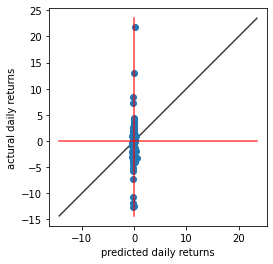

In [ ]:
show_prediction_scatter(prediction, actual)

In [ ]:
top10 = lgbm_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 1.0197004076132665
        prediction     actual
6869.T    0.591632  -3.272254
6532.T    0.395340  -1.932367
2413.T    0.283582   1.004414
4062.T    0.190477   0.355240
6920.T    0.162493  -0.204173
2127.T    0.153824  -3.982542
7733.T    0.118696  -1.587654
9984.T    0.080686  -2.088083
7747.T    0.073039  21.762783
3774.T    0.071720   0.141639


# Merge Results

In [ ]:
merged_result = pd.concat(
    [
        rf_result.add_prefix('rf_'),
        rf2_result.add_prefix('rf2_'),
        xgb_result.add_prefix('xgb_'),
        lgbm_result.add_prefix('lgbm_')
    ], join='inner', axis=1)
merged_result.drop(['xgb_actual', 'lgbm_actual', 'rf2_actual'], axis=1, inplace=True)
merged_result['xgbclf'] = xgbclf_result.tolist()
merged_result.rename(columns={
    'rf_actual': 'actual',
    'rf_prediction': 'rf',
    'rf2_prediction': 'rf2',
    'xgb_prediction': 'xgb',
    'lgbm_prediction': 'lgbm'}, inplace=True)

In [ ]:
merged_result.head()

,rf,actual,rf2,xgb,lgbm,xgbclf
7203.T,1.919435,2.283771,1.998648,1.214168,1.273826,1
1306.T,-0.845325,-0.995152,-0.778295,0.432227,0.976003,1
9432.T,0.339672,0.548876,0.471333,0.564770,0.904455,1
6758.T,3.018888,3.647276,3.066703,1.624202,1.225324,1
6861.T,2.670501,2.981030,2.453363,1.257706,1.294783,1


## Stacking prediction

### Stacking predict

In [ ]:
final_pred = ridge.predict(merged_result.drop(['actual'], axis=1))

In [ ]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-16
Ticker: 9468.T
Predicted max daily return: 1.7172318623202076


In [ ]:
data = {
    'prediction': list(final_pred),
    'actual': [merged_result['actual'].iloc[i] for i in range(len(prediction))],
}

final_result = pd.DataFrame(data)
final_result.index = [i for i in merged_result.index]

### Result

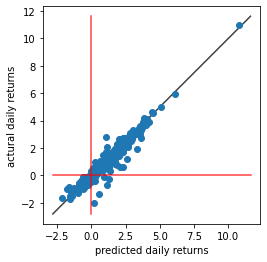

In [ ]:
show_prediction_scatter(final_pred, actual)

In [ ]:
top10 = final_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 5.061735035972006
        prediction     actual
8267.T   10.750336  10.971524
7936.T    6.101390   5.953878
7532.T    5.073610   4.967386
3769.T    4.505261   4.523580
2127.T    4.455358   4.594767
2897.T    4.193073   3.915344
2181.T    4.094531   4.095164
6758.T    3.985165   3.647276
4528.T    3.967335   3.971429
4689.T    3.962731   3.977002


## merge by adding all prediction

In [ ]:
merged_result["prediction"] = (merged_result['rf'] + merged_result['xgb'] + merged_result['lgbm'])/3

In [ ]:
top10 = merged_result.drop(columns=['rf', 'xgb', 'lgbm', 'rf2', 'xgbclf']).sort_values(by='prediction', ascending=False).head(10)
print(f"average: {top10['actual'].sum()/10}")
print(top10)

average: 4.9706190399744505
           actual  prediction
8267.T  10.971524    3.644255
2127.T   4.594767    2.675912
3769.T   4.523580    2.528742
7936.T   5.953878    2.436029
6098.T   4.189526    2.233486
2181.T   4.095164    2.208628
6920.T   2.504526    2.158538
7532.T   4.967386    2.096885
3092.T   3.928836    2.060984
4689.T   3.977002    2.052046


In [ ]:
merged_result.sort_values(by='prediction', ascending=False).head(10)["actual"].sum()/10

4.9706190399744505

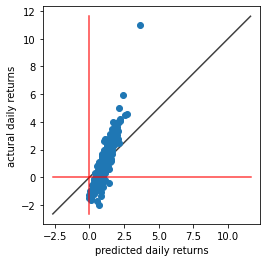

In [ ]:
show_prediction_scatter(merged_result['prediction'], merged_result['actual'])

## Using classification probability

In [ ]:
top10 = xgbclf_proba.sort_values(by=1, ascending=False).index

In [ ]:
top10_prob = merged_result.loc[top10]['actual']
print(f"average: {top10_prob.head(10).sum()/ 10}")
top10_prob.head(10)

average: 1.5637784152463972


6723.T    1.693480
7731.T    1.147776
8355.T    0.765306
3291.T    2.870813
4004.T    1.009637
8031.T    1.063638
8697.T    0.968758
3269.T    1.538462
2002.T    1.918317
6504.T    2.661597
Name: actual, dtype: float64

# Compare

In [ ]:
buying_num = 10

xgb_ave = xgb_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
lgbm_ave = lgbm_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
rf_ave = rf_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num

stack_ave = final_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
summing_ave = merged_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
percentage_ave = top10_prob.head(buying_num).sum()/buying_num

data = {
    "daily return": [xgb_ave, lgbm_ave, rf_ave, stack_ave, summing_ave, percentage_ave]
}

pd.DataFrame(data, index=['xgb', 'lgbm', 'rf', 'stack', 'summing', 'percentage_ave'])

,daily return
xgb,4.343025
lgbm,2.560278
rf,5.093402
stack,5.061735
summing,4.970619
percentage_ave,1.563778
